# Dataset generation and exploratory data analysis

In [1]:
# add parent dir to path
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

from pathlib import Path
from params import PATH_DATA, PATH_OUT

import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter

from tqdm.notebook import tqdm

import matplotlib.image as mpimg

## Labels distribution
Labels are enoded in filename. It is the word after the last underscore, before the dot.

In [2]:
fnames = list(PATH_DATA.glob("*.csv"))

def get_label(fname):
    return fname.name.split('.')[0].split('_')[-1]

labels = [get_label(fname) for fname in fnames]
c = Counter(labels)
c

Counter({'OK': 927, 'FAILED': 385})

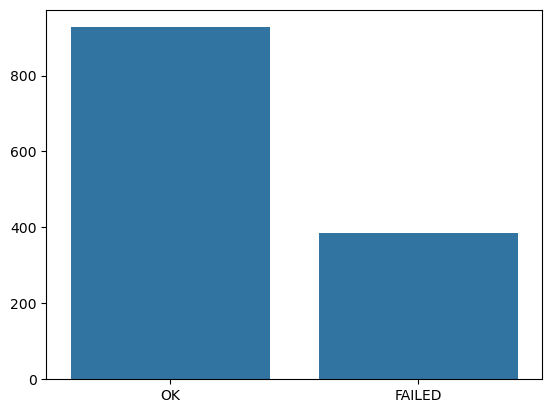

In [3]:
# plot the distribution of the labels
sns.barplot(x=list(c.keys()), y=list(c.values()));

We see that we have a binary classification problem with unbalanced dataset.

## Extract arrays from the `.csv` files and save them to `.npy` format

In [4]:
path_data_npy = PATH_OUT / "data_npy"
path_data_npy.mkdir(exist_ok=True)

In [5]:
for fname in tqdm(os.listdir(PATH_DATA)):
    name = fname.split('.')[0]
    df = pd.read_csv(PATH_DATA / fname, index_col=0)
    values = df.values
    # fill NA values with 0
    values = np.nan_to_num(values)
    np.save(path_data_npy / f"{name}.npy", values)

  0%|          | 0/1312 [00:00<?, ?it/s]

## Explore shapes distribution of images

In [6]:
shapes = []
for fname in tqdm(os.listdir(path_data_npy)):
    name = fname.split('.')[0]
    values = np.load(path_data_npy / fname)
    shapes.append(values.shape)

  0%|          | 0/1312 [00:00<?, ?it/s]

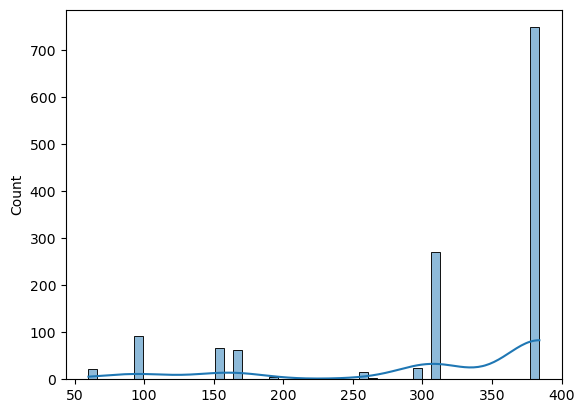

In [7]:
areas = [shape[0] * shape[1] for shape in shapes]
sns.histplot(areas, kde=True, bins=50);

## Select entries with the most common shape
So we see there is a subgroup of a large images. Let's select those as a candidates for our POC.

In [8]:
c = Counter(areas)
most_common_areas = c.most_common(5)

In [9]:
most_common_areas

[(384, 749), (308, 270), (96, 92), (154, 66), (168, 63)]

So, we have `749` of arrays with area value `384`. Select `.npy` files that has an area `384`:

In [10]:
MOST_COMMON_AREA = most_common_areas[0][0]
fnames_most_common_areas = []
shapes_most_common_areas = []
for fname in tqdm(os.listdir(path_data_npy)):
    name = fname.split('.')[0]
    values = np.load(path_data_npy / fname)
    area = values.shape[0] * values.shape[1]
    if area == MOST_COMMON_AREA:
        fnames_most_common_areas.append(name)
        shapes_most_common_areas.append(values.shape)

  0%|          | 0/1312 [00:00<?, ?it/s]

In [11]:
assert len(fnames_most_common_areas) == most_common_areas[0][1]

In [12]:
Counter(shapes_most_common_areas)

Counter({(16, 24): 749})

They have the same shape, so no shape adjustment is needed. What about labels distribution?

In [13]:
labels_most_common = [get_label(Path(fname)) for fname in fnames_most_common_areas]

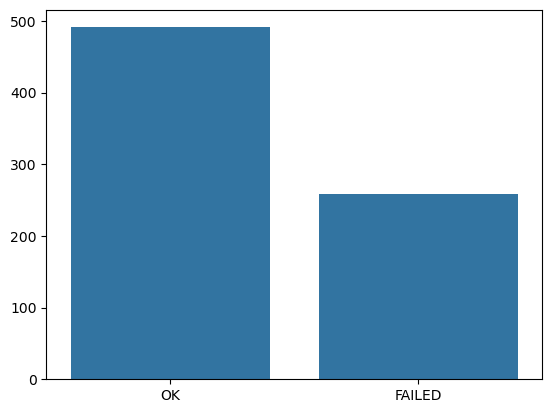

In [14]:
c = Counter(labels_most_common)
sns.barplot(x=list(c.keys()), y=list(c.values()));

In [15]:
Counter(labels_most_common)

Counter({'OK': 491, 'FAILED': 258})

In [16]:
# save the most common area filenames to text file
with open(PATH_OUT / 'fnames_most_common_areas.txt', 'w') as f:
    for item in fnames_most_common_areas:
        f.write("%s.npy\n" % item)

Copy this selected subset to the new folder:

In [18]:
path_to = PATH_OUT / "data_classifier/"
path_to.mkdir(exist_ok=True)
for fname in tqdm(fnames_most_common_areas):
    npy = np.load(path_data_npy / f"{fname}.npy")
    np.save(path_to / f"{fname}.npy", npy)

  0%|          | 0/749 [00:00<?, ?it/s]

Extra step - convert `.npy` files to `.png` format:

In [19]:
path_npy = PATH_OUT / "data_classifier"
path_png = PATH_OUT / "data_classifier_png"
path_png.mkdir(exist_ok=True)

In [20]:
# iterate over all files in the path_npy folder
for fname in tqdm(os.listdir(path_npy)):
    name = fname.split('.')[0]
    npy = np.load(path_npy / fname)
    mpimg.imsave(path_png / f"{name}.png", npy)

  0%|          | 0/749 [00:00<?, ?it/s]